# Autoencoder Recommendation System

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from collections import Counter
import ast

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist

## Data Preparation

In [112]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
Books_number = 2000
df_books = df_books.iloc[:Books_number]
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']

In [113]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

modified_df_ratings = df_ratings.merge(
    df[['goodreads_book_id']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in modified_df_ratings.groupby('user_id'):
    modified_books_ratings = group[['book_id', 'rating']].values.tolist()
    sparse_users[user_id] = modified_books_ratings

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
#user taken
taken_users = 50000
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:taken_users]
filter_users = dict(filter_users)

In [114]:
mapping_pos_to_books = dict(zip(range(Books_number), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(Books_number)))
mapping_pos_to_users = dict(zip(range(taken_users), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(taken_users)))

In [ ]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, book_rating in filter_users.items():
    vector = np.zeros(n_books)  # initialize vector with zeros

    for book_id, rating in book_rating:
        if book_id in mapping_books_to_pos:  # if book_id is in the mapping
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # insert rating in the correct position

    user_vectors.append(vector)
    
print("Number of Users", len(user_vectors))
print("Number of Books", len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 3 else 1 for elem in user_vectors[i]]
print("Example of a user: ", user_vectors[0][:20])
df_input_data = pd.DataFrame(user_vectors)

Number of Users 48939
Number of Books 2000
Example of a user:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Clustering

In [117]:
def string_to_list(stringa):
    lista = [elemento.strip() for elemento in stringa.split(",")]
    for i, element in enumerate(lista):
        lista[i] = element.strip('[').strip(']').strip('\'')
    return lista

df_books['tags_list'] = df_books['tags_list'].apply(string_to_list)

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_books['tags_string'])

In [119]:
from sklearn.cluster import KMeans

k = 8
kmeans_model = KMeans(n_clusters=k, random_state=3, max_iter=1000, n_init=10)
df_books['cluster'] = kmeans_model.fit_predict(X)

In [120]:
cluster_counts = df_books['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} elements")

Cluster 0: 247 elements
Cluster 1: 264 elements
Cluster 2: 318 elements
Cluster 3: 157 elements
Cluster 4: 269 elements
Cluster 5: 474 elements
Cluster 6: 56 elements
Cluster 7: 215 elements


In [121]:
def print_top_tags_per_cluster(df, top_n=20):

    for cluster_id in sorted(df['cluster'].unique()):
        tags = df[df['cluster'] == cluster_id]['tags_list'].explode()
        tag_counts = Counter(tags)
        most_common = tag_counts.most_common(top_n)
        print(f"\nCluster {cluster_id}:")
        for tag, count in most_common:
            print(f"  {tag}")

In [122]:
print_top_tags_per_cluster(df_books, top_n=10)


Cluster 0:
  sci-fi-fantasy
  fantasy
  favorites
  fiction
  books-i-own
  currently-reading
  library
  owned
  owned-books
  favourites

Cluster 1:
  owned
  owned-books
  books-i-own
  library
  currently-reading
  to-buy
  favorites
  default
  my-library
  non-fiction

Cluster 2:
  fantasy
  owned
  fiction
  books-i-own
  favorites
  i-own
  currently-reading
  library
  series
  favourites

Cluster 3:
  mystery
  favorites
  mystery-thriller
  kindle
  ebook
  fiction
  books-i-own
  owned-books
  currently-reading
  thriller

Cluster 4:
  fiction
  favorites
  literature
  books-i-own
  owned
  my-books
  to-buy
  default
  adult
  my-library

Cluster 5:
  favorites
  fiction
  owned
  books-i-own
  currently-reading
  owned-books
  library
  contemporary
  kindle
  to-buy

Cluster 6:
  fiction
  owned
  library
  my-library
  fantasy
  suspense
  adult
  my-books
  ebooks
  currently-reading

Cluster 7:
  children-s
  children-s-lit
  favorites
  kids-books
  fiction
  child

## Training

In [8]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [9]:
def train(model, dataloader, criterion, optimizer, num_epochs, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)
            loss = criterion(recon, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.10f}")
    return losses

In [10]:
def loss_graph(tr_loss,n_epochs):
    plt.plot(range(n_epochs),tr_loss,label='tr_loss', c='black')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

In [ ]:
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
model = Spatial_F_AE(Books_number)

It the model is already trained and you see the best_model.pth file in the repository you can avoid retraining and run the followinc cell to sideload the weights of the model

In [ ]:
# model.load_state_dict(torch.load('best_model.pth'))

Actual train of the model:

/Users/matteovicenzino/Documents/UNI/3_anno_24_25/ML/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Loss = 0.0046096686
Epoch 2: Loss = 0.0029974223
Epoch 3: Loss = 0.0029967277
Epoch 4: Loss = 0.0029953337
Epoch 5: Loss = 0.0029948202
Epoch 6: Loss = 0.0029933355
Epoch 7: Loss = 0.0029923831
Epoch 8: Loss = 0.0029915371
Epoch 9: Loss = 0.0029896746
Epoch 10: Loss = 0.0029888002
Epoch 11: Loss = 0.0029876270
Epoch 12: Loss = 0.0029869558
Epoch 13: Loss = 0.0029849202
Epoch 14: Loss = 0.0029840765
Epoch 15: Loss = 0.0029826695
Epoch 16: Loss = 0.0029819124
Epoch 17: Loss = 0.0029797925
Epoch 18: Loss = 0.0029791501
Epoch 19: Loss = 0.0029783744
Epoch 20: Loss = 0.0029770509


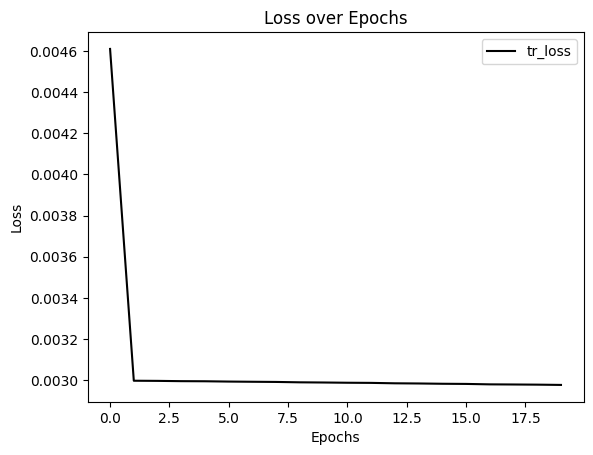

In [ ]:
criterion = nn.MSELoss()
N_Epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False)

losses = train(model,dataloader,criterion, optimizer, N_Epochs, scheduler)
loss_graph(losses, N_Epochs)

## Find Recommendations

In [128]:
def recommendations(user, model, n=25):
    model.eval()
    recon = model(user)
    old_books= (user != 0).nonzero(as_tuple=True)[0].tolist()
    _, new_books = torch.topk(recon, n) # top recommendations
    new_books = new_books.tolist()
    old_books_map = [mapping_pos_to_books[pos] for pos in old_books]
    new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
    old_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in old_books_map]
    new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]
    diff = list(set(new_titles) - set(old_titles))
    diff_id = list(set(new_books_map) - set(old_books_map))
    return diff, diff_id, old_books_map

In [132]:
def print_recommendations(user, n=25):
    rec, rec_id, old_id = recommendations(dataloader.dataset[user][0], model, n)

    print("#############################################\n")
    print(f"Top {n} recommendations for user {user}\n")
    [print(i) for i in rec]
    print("\n#############################################")

## Generate new user

In [ ]:
def choose_clusters():
    return 0

## Evaluating

In [18]:
def user_refinding(model,user):
    rating_pos = user[user == 1.0]
    if len(rating_pos) != 0:
        removed_pos = rating_pos[:int(len(rating_pos)/5)+1]
        removed_books = [mapping_pos_to_books[elem] for elem in removed_pos.tolist()]
        _, diff_id, _ = recommendations(user, model)
        diff = list(set(removed_books) - set(diff_id))
        return len(diff)/len(removed_books), len(removed_books)
    else:
        return 0,0

In [ ]:
sum = 0
for i in range(len(mapping_users_to_pos)):
    len_ratio, _ = user_refinding(model, dataloader.dataset[i][0])
    sum += len_ratio
print('On avg we refind: ', sum/len(mapping_users_to_pos), "% of the removed items")

## Example of use

In [133]:
print_recommendations(678, 20)

#############################################

Top 20 recommendations for user 678

Of Mice and Men
Heart of Darkness
The Kill Order (Maze Runner, #0.5)
Memoirs of a Geisha
Best Friends Forever
Before They Are Hanged (The First Law #2)
Angels & Demons  (Robert Langdon, #1)
The Fellowship of the Ring (The Lord of the Rings, #1)
The Odyssey
The Curious Incident of the Dog in the Night-Time
Wool Omnibus (Silo, #1)
Life of Pi
The Da Vinci Code (Robert Langdon, #2)

#############################################
